In [1]:
import xupy as xp
import matplotlib.pyplot as plt

from arte.types.mask import CircularMask
from ekarus.e2e.devices.pyramid_wfs import PyramidWFS
from ekarus.e2e.devices.pyr3_wfs import Pyr3WFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [ ]:
def slopes_cov(slopes, ron, method:str='slopes'):
    """
    slopes : (nfaces, Npix)
    returns C_int (diagonal) or C_slope (full).
    """
    var_map = slopes + ron**2 # (nfaces, Npix)

    if method == 'raw_intensity':
        C_diag = var_map.reshape(var_map.size)
        return xp.diag(C_diag)
    
    nfaces = slopes.shape[0]
    Npix = slopes.shape[1]
    I = slopes
    S = xp.sum(I)/Npix # mean intensity per pixel
    sxy = None
        
    if method == 'all_slopes' or method == 'diagonal_slopes':

        if nfaces == 4: # four‑faced pyramid
            sx  = (I[0] + I[2] - I[1] - I[3]) / S
            sy  = (I[0] + I[1] - I[2] - I[3]) / S
            sxy = (I[0] + I[3] - I[2] - I[1]) / S
            # Jacobian blocks (3×4)
            def block(sx_, sy_, sxy_, S_):
                return xp.asarray([
                    [( 1 - sx_ ) / S_, (-1 - sx_ ) / S_, ( 1 - sx_ ) / S_, (-1 - sx_ ) / S_],
                    [( 1 - sy_ ) / S_, ( 1 - sy_ ) / S_, (-1 - sy_ ) / S_, (-1 - sy_ ) / S_],
                    [( 1 - sxy_) / S_, (-1 - sxy_) / S_, (-1 - sxy_) / S_, ( 1 - sxy_) / S_]
                ], dtype=float)
        else: # three‑faced pyramid
            sx = (I[0] - (I[1] + I[2])/2) / S
            sy = (I[1] - (I[2] + I[0])/2) / S
            def block(sx_, sy_, S_):
                return xp.asarray([
                    [( 1 - sx_) / S_, (-1/2 - sx_) / S_, (-1/2 - sx_) / S_],
                    [(-1/2 - sy_) / S_, ( 1 - sy_) / S_, (-1/2 - sy_) / S_]
                ], dtype=float)

    else:#   case 'slopes':
        I = slopes
        S = xp.sum(I)/Npix # mean intensity per pixel

        if nfaces == 4: # four‑faced pyramid
            sx = (I[0] + I[2] - I[1] - I[3]) / S
            sy = (I[0] + I[1] - I[2] - I[3]) / S
            # Jacobian blocks (2×4)
            def block(sx_, sy_, S_):
                return xp.asarray([
                    [( 1 - sx_) / S_, (-1 - sx_) / S_, ( 1 - sx_) / S_, (-1 - sx_) / S_],
                    [( 1 - sy_) / S_, ( 1 - sy_) / S_, (-1 - sy_) / S_, (-1 - sy_) / S_]
                ], dtype=float)
        else: # three‑faced pyramid
            sx = (I[0] - (I[1] + I[2])/2) / S
            sy = xp.sqrt(3)/2 * (I[1] - I[2]) / S
            def block(sx_, sy_, S_):
                return xp.asarray([
                    [( 1 - sx_) / S_, (-1/2 - sx_) / S_, (-1/2 - sx_) / S_],
                    [ 0 , xp.sqrt(3)/2*(1 - sy_) / S_, -xp.sqrt(3)/2*(1 + sy_) / S_]
                ], dtype=float)
        
    N = int(2+(sxy is not None))
    rows, cols = N * Npix, nfaces * Npix
    B = xp.zeros((rows, cols), dtype=float)
    for p in range(Npix):        
        if sxy is not None:
            blk = block(sx[p], sy[p], sxy[p], S)
        else:
            blk = block(sx[p], sy[p], S)
        B[N*p:N*p+N, nfaces*p:nfaces*p+nfaces] = xp.asarray(blk, dtype=float)

    C_I = xp.diag(var_map.reshape(nfaces * Npix))
    return B @ C_I @ B.T

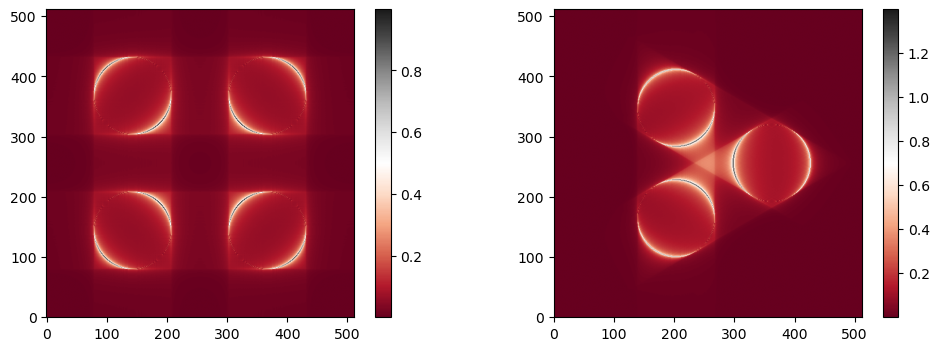

In [3]:
Npix = 128

# Create pupil mask
oversampling = 4
mask = CircularMask((Npix,Npix), maskRadius=Npix // 2)

pupilDiameterInM = 8.0
lambdaInM = 750e-9
lambdaOverD = lambdaInM/pupilDiameterInM

apex_angle = 112*(2*xp.pi)*lambdaOverD
pyr = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)
apex3_angle = (Npix+60)/(3*xp.cos(xp.pi/6))*(2*xp.pi)*lambdaOverD
pyr3 = Pyr3WFS(apex3_angle, oversampling, sensorLambda=lambdaInM)

piston = xp.array(mask.asTransmissionValue())

padded_field = xp.pad(piston, int((oversampling-1)/2*Npix), mode='constant', constant_values=0.0)
output_field = pyr.propagate(padded_field, lambdaOverD)
intensity = xp.abs(output_field**2)
output_field = pyr3.propagate(padded_field, lambdaOverD)
intensity3 = xp.abs(output_field**2)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(intensity),origin='lower',cmap='RdGy')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(intensity3),origin='lower',cmap='RdGy')
plt.colorbar()

In [4]:
# Define detector
RON = 0.3
detector_shape = (160,160)
ccd = Detector(detector_shape=detector_shape, RON=RON)
ccd3 = Detector(detector_shape=detector_shape, RON=RON)

Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps


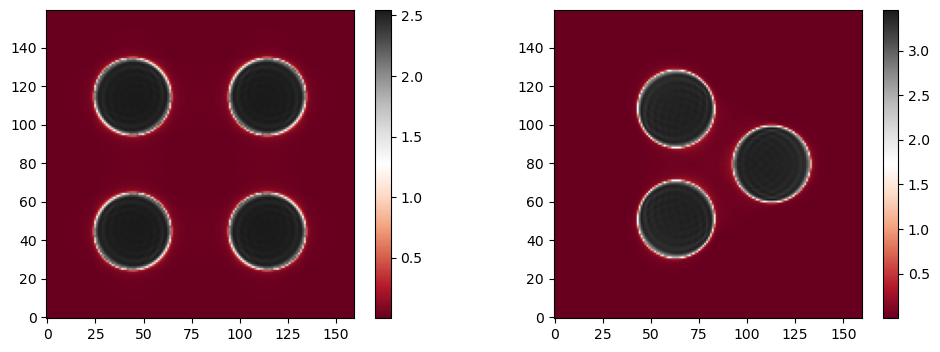

In [5]:
method = 'raw_intensity'
pars = {'modulationInLambdaOverD':3, 'slope_method': method}
sc = SlopeComputer(pyr, ccd, pars)
sc.calibrate_sensor(tn='', prefix_str='', recompute=True, zero_phase=xp.asarray(mask.asTransmissionValue()), lambdaOverD=lambdaOverD, Npix=42, centerObscurationInPixels=0.0)

sc3 = SlopeComputer(pyr3, ccd3, pars)
sc3.calibrate_sensor(tn='', prefix_str='', recompute=True, zero_phase=xp.asarray(mask.asTransmissionValue()), lambdaOverD=lambdaOverD, Npix=42, centerObscurationInPixels=0.0)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(ccd.last_frame),origin='lower',cmap='RdGy')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(ccd3.last_frame),origin='lower',cmap='RdGy')
plt.colorbar()

Modulating 0 [lambda/D] with 0 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps


Text(0.5, 1.0, 'Light lost to diffraction: 35%')

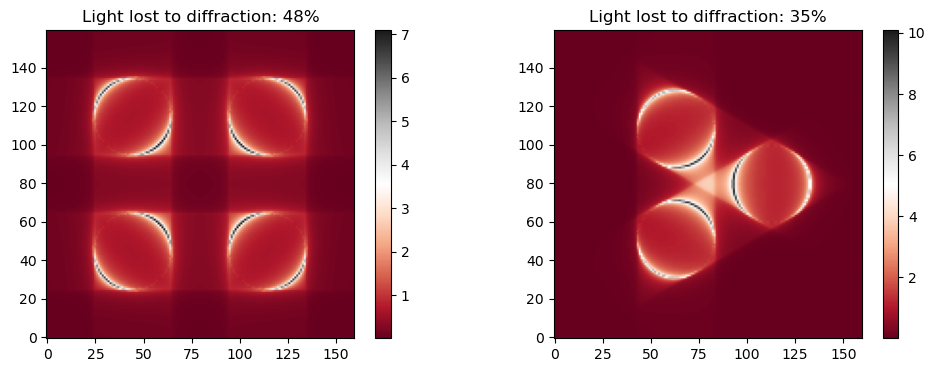

In [6]:
# Compute light lost to diffraction
pyr.set_modulation_angle(0.0)
output_field = pyr.propagate(padded_field, lambdaOverD)
intensity = ccd.image_on_detector(xp.abs(output_field**2))
tot_intensity = xp.sum(intensity)
pup_intensity = xp.sum(xp.hstack([intensity[~sc._roi_masks[i]] for i in range(4)]))
loss = 1-pup_intensity/tot_intensity

pyr3.set_modulation_angle(0.0)
output_field = pyr3.propagate(padded_field, lambdaOverD)
intensity3 = ccd3.image_on_detector(xp.abs(output_field**2))
tot3_intensity = xp.sum(intensity)
pup3_intensity = xp.sum(xp.hstack([intensity3[~sc3._roi_masks[i]] for i in range(3)]))
loss3 = 1-pup3_intensity/tot3_intensity

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(ccd.last_frame),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title(f'Light lost to diffraction: {loss*1e+2:1.0f}%')
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(ccd3.last_frame),origin='lower',cmap='RdGy')
plt.colorbar()
plt.title(f'Light lost to diffraction: {loss3*1e+2:1.0f}%')

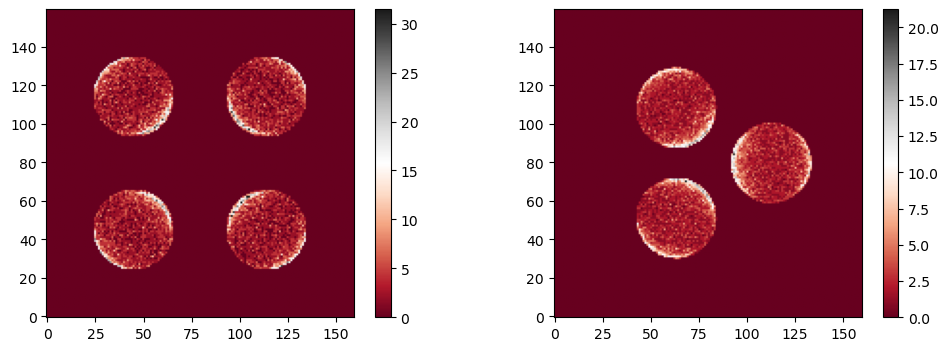

In [7]:
Nphot = 1e+4
slopes = sc.compute_slopes(piston, lambdaOverD, nPhotons=Nphot)
slopes3 = sc3.compute_slopes(piston, lambdaOverD, nPhotons=Nphot)

# slopes = xp.vstack([ccd.last_frame[~sc._roi_masks[i]] for i in range(4)])
# slopes3 = xp.vstack([ccd3.last_frame[~sc3._roi_masks[i]] for i in range(3)])

cov = slopes_cov(slopes, ron=RON, method=sc._slope_method)
cov3 = slopes_cov(slopes3, ron=RON, method=sc3._slope_method)

img = xp.zeros_like(ccd.last_frame)
start = 0
end = 0
for i in range(4):
    end += xp.sum(1-sc._roi_masks[i])
    img[~sc._roi_masks[i]] = xp.diag(cov)[start:end]
    img = xp.reshape(img, ccd.detector_shape)
    start += xp.sum(1-sc._roi_masks[i])

img3 = xp.zeros_like(ccd3.last_frame)
start = 0
end = 0
for i in range(3):
    end += xp.sum(1-sc3._roi_masks[i])
    img3[~sc3._roi_masks[i]] = xp.diag(cov3)[start:end]
    img3 = xp.reshape(img3, ccd3.detector_shape)
    start += xp.sum(1-sc3._roi_masks[i])

# plt.figure()
# plt.plot(xp.asnumpy(xp.diag(cov)))
# plt.plot(xp.asnumpy(xp.diag(cov3)))
# plt.grid()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(xp.asnumpy(img),origin='lower',cmap='RdGy')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(xp.asnumpy(img3),origin='lower',cmap='RdGy')
plt.colorbar()